In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import os
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use('fivethirtyeight')

In [ ]:
'''!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf'''

'!sudo apt-get install -y fonts-nanum\n!sudo fc-cache -fv\n!rm ~/.cache/matplotlib -rf'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 불러오기

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/응통2021/추가 데이터/full_dataset.csv')

In [ ]:
df.head()

,Unnamed: 0,date,요일,품목,가격,거래량,주산지,경유가격,농산물,month_avg,temp,max_Temp,min_Temp,hum,wind,rain,sun_Qy,dif_Temp,p_lag_1,q_lag_1,p_lag_2,q_lag_2,p_lag_3,q_lag_3,p_lag_4,q_lag_4,p_lag_5,q_lag_5,p_lag_6,q_lag_6,p_lag_7,q_lag_7,p_ewma,q_ewma,month,1_week,2_week,4_week,q_lag_8,p_lag_8,q_lag_9,p_lag_9,q_lag_10,p_lag_10
0,0,2016-01-01,금요일,배추,0.0,0.0,전남,1191.69,101.55,531.653846,2.700000,9.300000,-3.300000,84.133333,0.366667,0.033333,9.033333,12.600000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,1.0,420.0,449.0,625.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2016-01-02,토요일,배추,329.0,80860.0,전남,1190.58,101.55,531.653846,6.133333,13.800000,0.233333,86.900000,0.333333,0.000000,5.933333,13.566667,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.466667,-0.466667,1.0,389.0,454.0,733.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2016-01-03,일요일,배추,0.0,0.0,전남,1189.58,101.55,531.653846,6.666667,15.233333,2.133333,89.800000,0.333333,0.000000,9.633333,13.100000,329.0,80860.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,124.301775,30621.248521,1.0,0.0,0.0,1048.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2016-01-04,월요일,배추,478.0,1422742.5,전남,1187.96,101.55,531.653846,6.133333,11.233333,-0.633333,81.233333,1.100000,0.000000,9.800000,11.866667,0.0,0.0,329.0,80860.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,86.754572,21371.644248,1.0,398.0,475.0,638.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2016-01-05,화요일,배추,442.0,1167241.0,전남,1185.81,101.55,531.653846,1.700000,4.066667,-1.300000,76.566667,0.400000,1.466667,1.900000,5.366667,478.0,1422742.5,0.0,0.0,329.0,80860.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,187.158135,380999.175428,1.0,431.0,511.0,597.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df = df[['date', '품목', '가격', '거래량', '경유가격', '농산물', 'temp', 'max_Temp', 'min_Temp', 'hum', 'wind', 'rain', 'sun_Qy', 'dif_Temp', '1_week']]
df.head()

,date,품목,가격,거래량,경유가격,농산물,temp,max_Temp,min_Temp,hum,wind,rain,sun_Qy,dif_Temp,1_week
0,2016-01-01,배추,0.0,0.0,1191.69,101.55,2.700000,9.300000,-3.300000,84.133333,0.366667,0.033333,9.033333,12.600000,420.0
1,2016-01-02,배추,329.0,80860.0,1190.58,101.55,6.133333,13.800000,0.233333,86.900000,0.333333,0.000000,5.933333,13.566667,389.0
2,2016-01-03,배추,0.0,0.0,1189.58,101.55,6.666667,15.233333,2.133333,89.800000,0.333333,0.000000,9.633333,13.100000,0.0
3,2016-01-04,배추,478.0,1422742.5,1187.96,101.55,6.133333,11.233333,-0.633333,81.233333,1.100000,0.000000,9.800000,11.866667,398.0
4,2016-01-05,배추,442.0,1167241.0,1185.81,101.55,1.700000,4.066667,-1.300000,76.566667,0.400000,1.466667,1.900000,5.366667,431.0


# 결측값 처리

샤인마스캇, 당근, 무, 양배추 품목 제외

In [ ]:
idx = df[(df['품목']=='샤인마스캇')|(df['품목']=='당근')|(df['품목']=='무')|(df['품목']=='양배추')].index
df = df.drop(idx)
df['품목'].unique()

array(['배추', '양파', '건고추', '마늘', '대파', '얼갈이배추', '깻잎', '시금치', '미나리', '파프리카',
       '새송이', '팽이버섯', '토마토', '청상추', '백다다기', '애호박', '캠벨얼리'], dtype=object)

#데이터 전처리

datetime으로 변환 & date를 index로 변경

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.index = df['date']
df = df.drop(['date'], axis=1)
df.head()

,품목,가격,거래량,경유가격,농산물,temp,max_Temp,min_Temp,hum,wind,rain,sun_Qy,dif_Temp,1_week
date,,,,,,,,,,,,,,
2016-01-01,배추,0.0,0.0,1191.69,101.55,2.700000,9.300000,-3.300000,84.133333,0.366667,0.033333,9.033333,12.600000,420.0
2016-01-02,배추,329.0,80860.0,1190.58,101.55,6.133333,13.800000,0.233333,86.900000,0.333333,0.000000,5.933333,13.566667,389.0
2016-01-03,배추,0.0,0.0,1189.58,101.55,6.666667,15.233333,2.133333,89.800000,0.333333,0.000000,9.633333,13.100000,0.0
2016-01-04,배추,478.0,1422742.5,1187.96,101.55,6.133333,11.233333,-0.633333,81.233333,1.100000,0.000000,9.800000,11.866667,398.0
2016-01-05,배추,442.0,1167241.0,1185.81,101.55,1.700000,4.066667,-1.300000,76.566667,0.400000,1.466667,1.900000,5.366667,431.0


컬럼 순서 지정

In [ ]:
df = df[['품목', '1_week', '농산물', '가격', '거래량', '경유가격', 'dif_Temp', 'max_Temp', 'min_Temp', 'temp', 'wind', 'rain']]
df.head()

,품목,1_week,농산물,가격,거래량,경유가격,dif_Temp,max_Temp,min_Temp,temp,wind,rain
date,,,,,,,,,,,,
2016-01-01,배추,420.0,101.55,0.0,0.0,1191.69,12.600000,9.300000,-3.300000,2.700000,0.366667,0.033333
2016-01-02,배추,389.0,101.55,329.0,80860.0,1190.58,13.566667,13.800000,0.233333,6.133333,0.333333,0.000000
2016-01-03,배추,0.0,101.55,0.0,0.0,1189.58,13.100000,15.233333,2.133333,6.666667,0.333333,0.000000
2016-01-04,배추,398.0,101.55,478.0,1422742.5,1187.96,11.866667,11.233333,-0.633333,6.133333,1.100000,0.000000
2016-01-05,배추,431.0,101.55,442.0,1167241.0,1185.81,5.366667,4.066667,-1.300000,1.700000,0.400000,1.466667


In [ ]:
df['dif_Temp'] = np.log1p(df['dif_Temp'])
df['min_Temp'] = np.log1p(df['min_Temp'])
df['max_Temp'] = np.log1p(df['max_Temp'])
df['temp'] = np.log1p(df['temp'])
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(method='backfill')

# 모델링

## 배추

결측치 처리

In [ ]:
bae = df[df['품목']=='배추']
bae = bae.drop(['품목'], axis=1)
bae.isnull().sum()

1_week      0
농산물         0
가격          0
거래량         0
경유가격        0
dif_Temp    0
max_Temp    0
min_Temp    0
temp        0
wind        0
rain        0
dtype: int64

정상성 확인 - H0 : 비정상성 vs H1 : 정상성

In [ ]:
for col, item in bae.iteritems() :
  adfuller_test = adfuller(bae[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -4.134980921955655
p-value: 0.0008473132427230017
농산물
ADF test statistic: -2.1287035587295784
p-value: 0.23313046089837702
가격
ADF test statistic: -1.8030389974378114
p-value: 0.37895396298178474
거래량
ADF test statistic: -5.816894620552082
p-value: 4.271654200572158e-07
경유가격
ADF test statistic: -2.878108112045438
p-value: 0.047953594019128624
dif_Temp
ADF test statistic: -5.951613894003769
p-value: 2.1405652738582303e-07
max_Temp
ADF test statistic: -3.048780266908163
p-value: 0.030583286374205983
min_Temp
ADF test statistic: -3.0138477562585058
p-value: 0.033621275450113564
temp
ADF test statistic: -2.596454673768401
p-value: 0.0937322304435726
wind
ADF test statistic: -7.636571842458714
p-value: 1.9452978645141846e-11
rain
ADF test statistic: -10.121100165331454
p-value: 9.440360688908869e-18


결론 : 농산물, 가격, 경유가격, temp 비정상성을 가짐

차분

In [ ]:
lst = ['농산물', '가격', '경유가격', 'temp']
for col in lst:
  bae_diff = np.diff(bae[col])
  bae[col] = np.append([0], bae_diff)
bae.isnull().sum()

1_week      0
농산물         0
가격          0
거래량         0
경유가격        0
dif_Temp    0
max_Temp    0
min_Temp    0
temp        0
wind        0
rain        0
dtype: int64

In [ ]:
for col, item in bae.iteritems() :
  adfuller_test = adfuller(bae[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -4.134980921955655
p-value: 0.0008473132427230017
농산물
ADF test statistic: -41.60771758203591
p-value: 0.0
가격
ADF test statistic: -10.096322549232685
p-value: 1.0884548346829093e-17
거래량
ADF test statistic: -5.816894620552082
p-value: 4.271654200572158e-07
경유가격
ADF test statistic: -5.039910776433685
p-value: 1.8491687377966486e-05
dif_Temp
ADF test statistic: -5.951613894003769
p-value: 2.1405652738582303e-07
max_Temp
ADF test statistic: -3.048780266908163
p-value: 0.030583286374205983
min_Temp
ADF test statistic: -3.0138477562585058
p-value: 0.033621275450113564
temp
ADF test statistic: -10.727994152293467
p-value: 3.03048531624028e-19
wind
ADF test statistic: -7.636571842458714
p-value: 1.9452978645141846e-11
rain
ADF test statistic: -10.121100165331454
p-value: 9.440360688908869e-18


결론 : 비정상성 해결

In [ ]:
train_size = int(0.85 * len(bae))

train = bae.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(bae.iloc[:train_size, 1:]), pd.DataFrame(bae.iloc[:train_size, 0])
x_test, y_test_bae = pd.DataFrame(bae.iloc[train_size:-7, 1:]), pd.DataFrame(bae.iloc[train_size:-7, 0])
y_test_bae

,1_week
date,
2020-01-13,754.0
2020-01-14,716.0
2020-01-15,741.0
2020-01-16,770.0
2020-01-17,659.0
...,...
2020-09-17,1839.0
2020-09-18,1789.0
2020-09-19,1760.0


In [ ]:
forecasting_model = VAR(train)
results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

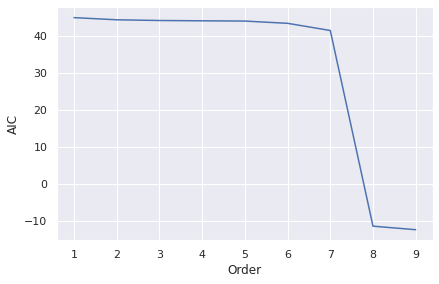

In [ ]:
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

p=9

In [ ]:
results = forecasting_model.fit(9)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Nov, 2021
Time:                     14:03:50
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -8.47741
Nobs:                     1464.00    HQIC:                  -10.9691
Log likelihood:          -12636.2    FPE:                3.92170e-06
AIC:                     -12.4513    Det(Omega_mle):     1.89593e-06
--------------------------------------------------------------------
Results for equation 1_week
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const             160.050449       104.757242            1.528           0.127
L1.1_week           0.137003         0.026953            5.083           0.000
L1.농산물             -1.821119         5.395346           -0.338     

In [ ]:
laaged_values = train.values[-9:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=len(y_test_bae)), index = y_test_bae.index)
forecast

,0,1,2,3,4,5,6,7,8,9,10
date,,,,,,,,,,,
2020-01-13,754.473986,0.262446,4.000000,1.113361e+06,0.017701,1.964962,2.011548,0.950424,-0.226690,1.447613,5.091685
2020-01-14,866.682689,0.231412,7.000000,6.838113e+05,0.060519,2.240405,2.157968,1.031686,0.033868,1.212672,3.964277
2020-01-15,800.278564,0.588274,16.000000,5.152963e+05,0.182868,2.265060,2.318547,1.102509,0.120162,1.223301,7.177167
2020-01-16,618.010561,0.625415,-14.000000,7.002633e+05,0.157535,2.240798,2.340070,1.242779,-0.069289,1.206330,3.818877
2020-01-17,818.081038,0.322183,20.000000,9.774727e+05,0.327842,2.305243,2.357082,1.229306,-0.037609,1.190549,1.779816
...,...,...,...,...,...,...,...,...,...,...,...
2020-09-17,568.623709,0.015660,-0.458109,1.161078e+06,0.182554,2.387364,2.890073,1.945633,0.001191,1.079071,3.502278
2020-09-18,576.891653,0.012207,8.971343,1.182634e+06,0.187447,2.387391,2.889656,1.946044,-0.003408,1.077642,3.485013
2020-09-19,575.416153,0.013593,-1.606943,1.163467e+06,0.179620,2.387929,2.889549,1.946979,0.001237,1.076651,3.532340


In [ ]:
y_pred_bae = forecast.iloc[:, 0]
y_pred_bae.head()
#from sklearn.metrics import mean_absolute_error, mean_squared_error
#import math
#score_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
#print('RMSE: {}'.format(score_rmse))

date
2020-01-13    754.473986
2020-01-14    866.682689
2020-01-15    800.278564
2020-01-16    618.010561
2020-01-17    818.081038
Name: 0, dtype: float64

## 양파

결측치 처리

In [ ]:
yang = df[df['품목']=='양파']
yang = yang.drop(['품목'], axis=1)
yang.isnull().sum()

1_week      0
농산물         0
가격          0
거래량         0
경유가격        0
dif_Temp    0
max_Temp    0
min_Temp    0
temp        0
wind        0
rain        0
dtype: int64

정상성 확인

In [ ]:
for col, item in yang.iteritems() :
  adfuller_test = adfuller(yang[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -2.9068033539377005
p-value: 0.04456256061277124
농산물
ADF test statistic: -2.1287035587295784
p-value: 0.23313046089837702
가격
ADF test statistic: -2.4203154027923284
p-value: 0.13608443753242028
거래량
ADF test statistic: -4.274986725721214
p-value: 0.0004906650592217304
경유가격
ADF test statistic: -2.878108112045438
p-value: 0.047953594019128624
dif_Temp
ADF test statistic: -5.951613894003769
p-value: 2.1405652738582303e-07
max_Temp
ADF test statistic: -3.048780266908163
p-value: 0.030583286374205983
min_Temp
ADF test statistic: -3.0138477562585058
p-value: 0.033621275450113564
temp
ADF test statistic: -2.596454673768401
p-value: 0.0937322304435726
wind
ADF test statistic: -7.636571842458714
p-value: 1.9452978645141846e-11
rain
ADF test statistic: -10.121100165331454
p-value: 9.440360688908869e-18


결론 : 농산물, 가격, 경유가격, temp 비정상성을 가짐

차분

In [ ]:
lst = ['가격', '경유가격', '농산물', 'temp']
for col in lst:
  yang_diff = np.diff(yang[col])
  yang[col] = np.append([0], yang_diff)

for col, item in yang.iteritems() :
  adfuller_test = adfuller(yang[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -2.9068033539377005
p-value: 0.04456256061277124
농산물
ADF test statistic: -41.60771758203591
p-value: 0.0
가격
ADF test statistic: -12.62073684451942
p-value: 1.580326900473859e-23
거래량
ADF test statistic: -4.274986725721214
p-value: 0.0004906650592217304
경유가격
ADF test statistic: -5.039910776433685
p-value: 1.8491687377966486e-05
dif_Temp
ADF test statistic: -5.951613894003769
p-value: 2.1405652738582303e-07
max_Temp
ADF test statistic: -3.048780266908163
p-value: 0.030583286374205983
min_Temp
ADF test statistic: -3.0138477562585058
p-value: 0.033621275450113564
temp
ADF test statistic: -10.727994152293467
p-value: 3.03048531624028e-19
wind
ADF test statistic: -7.636571842458714
p-value: 1.9452978645141846e-11
rain
ADF test statistic: -10.121100165331454
p-value: 9.440360688908869e-18


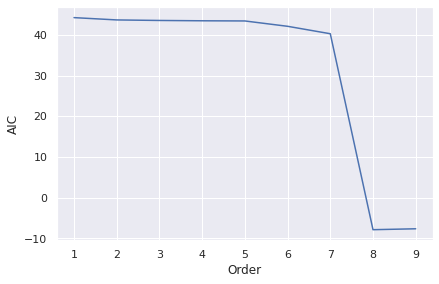

In [ ]:
train_size = int(0.85 * len(yang))

train = yang.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(yang.iloc[:train_size, 1:]), pd.DataFrame(yang.iloc[:train_size, 0])
x_test, y_test_yang = pd.DataFrame(yang.iloc[train_size:-7, 1:]), pd.DataFrame(yang.iloc[train_size:-7, 0])

forecasting_model = VAR(train)
results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
results = forecasting_model.fit(8)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Nov, 2021
Time:                     14:05:33
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -4.32706
Nobs:                     1465.00    HQIC:                  -6.54348
Log likelihood:          -16128.4    FPE:                0.000385781
AIC:                     -7.86189    Det(Omega_mle):     0.000201648
--------------------------------------------------------------------
Results for equation 1_week
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const             -12.513896        69.439201           -0.180           0.857
L1.1_week           0.268183         0.027080            9.903           0.000
L1.농산물             -5.103888         3.613060           -1.413     

In [ ]:
laaged_values = train.values[-8:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=len(y_test_yang)), index = y_test_yang.index)

y_pred_yang = forecast.iloc[:, 0]
y_pred_yang.head()

date
2020-01-13    771.509581
2020-01-14    835.157753
2020-01-15    812.862181
2020-01-16    780.698771
2020-01-17    833.888231
Name: 0, dtype: float64

## 건고추

결측치 처리

In [ ]:
gun = df[df['품목']=='건고추']
gun = gun.drop(['품목'], axis=1)
gun.isnull().sum()

1_week      0
농산물         0
가격          0
거래량         0
경유가격        0
dif_Temp    0
max_Temp    0
min_Temp    0
temp        0
wind        0
rain        0
dtype: int64

정상성 확인

In [ ]:
for col, item in gun.iteritems() :
  adfuller_test = adfuller(gun[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -3.998900223719718
p-value: 0.0014162809651212744
농산물
ADF test statistic: -2.1287035587295784
p-value: 0.23313046089837702
가격
ADF test statistic: -3.279109065038777
p-value: 0.01583851978219922
거래량
ADF test statistic: -6.4802083301684315
p-value: 1.3007099435336278e-08
경유가격
ADF test statistic: -2.878108112045438
p-value: 0.047953594019128624
dif_Temp
ADF test statistic: -5.951613894003769
p-value: 2.1405652738582303e-07
max_Temp
ADF test statistic: -3.048780266908163
p-value: 0.030583286374205983
min_Temp
ADF test statistic: -3.0138477562585058
p-value: 0.033621275450113564
temp
ADF test statistic: -2.596454673768401
p-value: 0.0937322304435726
wind
ADF test statistic: -7.636571842458714
p-value: 1.9452978645141846e-11
rain
ADF test statistic: -10.121100165331454
p-value: 9.440360688908869e-18


결론 : 경유가격, 농산물, temp 비정상성을 가짐 

차분

In [ ]:
lst = ['경유가격', '농산물', 'temp']
for col in lst:
  gun_diff = np.diff(gun[col])
  gun[col] = np.append([0], gun_diff)

for col, item in gun.iteritems() :
  adfuller_test = adfuller(gun[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -3.998900223719718
p-value: 0.0014162809651212744
농산물
ADF test statistic: -41.60771758203591
p-value: 0.0
가격
ADF test statistic: -3.279109065038777
p-value: 0.01583851978219922
거래량
ADF test statistic: -6.4802083301684315
p-value: 1.3007099435336278e-08
경유가격
ADF test statistic: -5.039910776433685
p-value: 1.8491687377966486e-05
dif_Temp
ADF test statistic: -5.951613894003769
p-value: 2.1405652738582303e-07
max_Temp
ADF test statistic: -3.048780266908163
p-value: 0.030583286374205983
min_Temp
ADF test statistic: -3.0138477562585058
p-value: 0.033621275450113564
temp
ADF test statistic: -10.727994152293467
p-value: 3.03048531624028e-19
wind
ADF test statistic: -7.636571842458714
p-value: 1.9452978645141846e-11
rain
ADF test statistic: -10.121100165331454
p-value: 9.440360688908869e-18


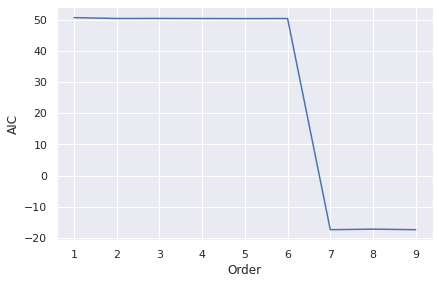

In [ ]:
train_size = int(0.85 * len(gun))

train = gun.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(gun.iloc[:train_size, 1:]), pd.DataFrame(gun.iloc[:train_size, 0])
x_test, y_test_gun = pd.DataFrame(gun.iloc[train_size:-7, 1:]), pd.DataFrame(gun.iloc[train_size:-7, 0])

forecasting_model = VAR(train)

results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
results = forecasting_model.fit(7)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Nov, 2021
Time:                     14:34:13
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -14.2882
Nobs:                     1466.00    HQIC:                  -16.2296
Log likelihood:          -9281.03    FPE:                2.82182e-08
AIC:                     -17.3844    Det(Omega_mle):     1.59545e-08
--------------------------------------------------------------------
Results for equation 1_week
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const           -1830.281629      2449.179362           -0.747           0.455
L1.1_week           0.023417         0.025962            0.902           0.367
L1.농산물            -10.781383       139.226128           -0.077     

In [ ]:
laaged_values = train.values[-7:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=len(y_test_gun)), index = y_test_gun.index)

y_pred_gun = forecast.iloc[:, 0]
y_pred_gun.head()

date
2020-01-13    12373.427648
2020-01-14     7846.241399
2020-01-15     9773.633768
2020-01-16     8491.972310
2020-01-17     8762.046247
Name: 0, dtype: float64

## 마늘

결측치 처리

In [ ]:
ma = df[df['품목']=='마늘']
ma = ma.drop(['품목'], axis=1)
ma.isnull().sum()

1_week      0
농산물         0
가격          0
거래량         0
경유가격        0
dif_Temp    0
max_Temp    0
min_Temp    0
temp        0
wind        0
rain        0
dtype: int64

정상성 확인

In [ ]:
for col, item in ma.iteritems() :
  adfuller_test = adfuller(ma[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -2.5948767979054628
p-value: 0.09406075899255367
농산물
ADF test statistic: -2.1287035587295784
p-value: 0.23313046089837702
가격
ADF test statistic: -2.125446999087175
p-value: 0.23440609433683562
거래량
ADF test statistic: -5.28847838762541
p-value: 5.784719812093418e-06
경유가격
ADF test statistic: -3.083193660920752
p-value: 0.02782219257057328
dif_Temp
ADF test statistic: -6.104086611718888
p-value: 9.678357489582787e-08
max_Temp
ADF test statistic: -3.7782966856148086
p-value: 0.0031373394282818803
min_Temp
ADF test statistic: -2.8365015710838333
p-value: 0.05324597300976967
temp
ADF test statistic: -3.1141440347146805
p-value: 0.025524019924926217
wind
ADF test statistic: -17.548960751327602
p-value: 4.151977961331234e-30
rain
ADF test statistic: -8.522991522598309
p-value: 1.0879212663915307e-13


결론 : 가격, 농산물, min_Temp, 1_week 비정상성을 가짐 

차분

In [ ]:
#test data 미리 빼놓기
y_test_ma = pd.DataFrame(ma.iloc[train_size:-7, 0])

lst = ['가격', '농산물', 'min_Temp', '1_week']
for col in lst:
  ma_diff = np.diff(ma[col])
  ma[col] = np.append([0], ma_diff)

for col, item in ma.iteritems() :
  adfuller_test = adfuller(ma[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -9.144186579110542
p-value: 2.7966693909589463e-15
농산물
ADF test statistic: -41.60771758203591
p-value: 0.0
가격
ADF test statistic: -11.068566159672962
p-value: 4.614880214766067e-20
거래량
ADF test statistic: -5.28847838762541
p-value: 5.784719812093418e-06
경유가격
ADF test statistic: -3.083193660920752
p-value: 0.02782219257057328
dif_Temp
ADF test statistic: -6.104086611718888
p-value: 9.678357489582787e-08
max_Temp
ADF test statistic: -3.7782966856148086
p-value: 0.0031373394282818803
min_Temp
ADF test statistic: -13.654425041793546
p-value: 1.563565680778862e-25
temp
ADF test statistic: -3.1141440347146805
p-value: 0.025524019924926217
wind
ADF test statistic: -17.548960751327602
p-value: 4.151977961331234e-30
rain
ADF test statistic: -8.522991522598309
p-value: 1.0879212663915307e-13


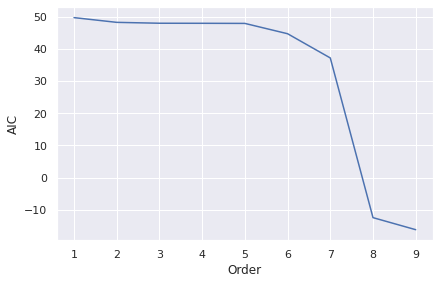

In [ ]:
train_size = int(0.85 * len(ma))

train = ma.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(ma.iloc[:train_size, 1:]), pd.DataFrame(ma.iloc[:train_size, 0])
x_test, y_test_ma1 = pd.DataFrame(ma.iloc[train_size:-7, 1:]), pd.DataFrame(ma.iloc[train_size:-7, 0])

forecasting_model = VAR(train)

results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
results = forecasting_model.fit(9)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Nov, 2021
Time:                     14:34:54
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -12.2775
Nobs:                     1464.00    HQIC:                  -14.7692
Log likelihood:          -9854.52    FPE:                8.77202e-08
AIC:                     -16.2515    Det(Omega_mle):     4.24079e-08
--------------------------------------------------------------------
Results for equation 1_week
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const             -65.354370       466.735910           -0.140           0.889
L1.1_week          -0.722460         0.026794          -26.963           0.000
L1.농산물            -36.256002        17.240211           -2.103     

In [ ]:
laaged_values = train.values[-9:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=len(y_test_ma1)), index = y_test_ma1.index)

# 차분한 값에 원 데이터 더하기
y_pred_ma = forecast.iloc[:, 0].cumsum() + y_test_ma.iloc[:, 0]
y_pred_ma.head()

date
2020-01-13    5131.482702
2020-01-14    5983.037732
2020-01-15    5138.570034
2020-01-16    5641.824010
2020-01-17    5925.742731
dtype: float64

## 대파

결측치 처리

In [ ]:
dae = df[df['품목']=='대파']
dae = dae.drop(['품목'], axis=1)
dae.isnull().sum()

1_week      0
농산물         0
가격          0
거래량         0
경유가격        0
dif_Temp    0
max_Temp    0
min_Temp    0
temp        0
wind        0
rain        0
dtype: int64

정상성 확인

In [ ]:
for col, item in dae.iteritems() :
  adfuller_test = adfuller(dae[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -4.20742513689187
p-value: 0.0006400883512369443
농산물
ADF test statistic: -2.1287035587295784
p-value: 0.23313046089837702
가격
ADF test statistic: -2.844806868111213
p-value: 0.05215296889007357
거래량
ADF test statistic: -4.31627709653524
p-value: 0.00041624865227042434
경유가격
ADF test statistic: -2.878108112045438
p-value: 0.047953594019128624
dif_Temp
ADF test statistic: -5.951613894003769
p-value: 2.1405652738582303e-07
max_Temp
ADF test statistic: -3.048780266908163
p-value: 0.030583286374205983
min_Temp
ADF test statistic: -3.0138477562585058
p-value: 0.033621275450113564
temp
ADF test statistic: -2.596454673768401
p-value: 0.0937322304435726
wind
ADF test statistic: -7.636571842458714
p-value: 1.9452978645141846e-11
rain
ADF test statistic: -10.121100165331454
p-value: 9.440360688908869e-18


결론 : 가격, 경유가격, 농산물, temp 비정상성을 가짐 

차분

In [ ]:
lst = ['가격', '경유가격', '농산물', 'temp']
for col in lst:
  dae_diff = np.diff(dae[col])
  dae[col] = np.append([0], dae_diff)

for col, item in dae.iteritems() :
  adfuller_test = adfuller(dae[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -4.20742513689187
p-value: 0.0006400883512369443
농산물
ADF test statistic: -41.60771758203591
p-value: 0.0
가격
ADF test statistic: -10.61953821558044
p-value: 5.561342608064528e-19
거래량
ADF test statistic: -4.31627709653524
p-value: 0.00041624865227042434
경유가격
ADF test statistic: -5.039910776433685
p-value: 1.8491687377966486e-05
dif_Temp
ADF test statistic: -5.951613894003769
p-value: 2.1405652738582303e-07
max_Temp
ADF test statistic: -3.048780266908163
p-value: 0.030583286374205983
min_Temp
ADF test statistic: -3.0138477562585058
p-value: 0.033621275450113564
temp
ADF test statistic: -10.727994152293467
p-value: 3.03048531624028e-19
wind
ADF test statistic: -7.636571842458714
p-value: 1.9452978645141846e-11
rain
ADF test statistic: -10.121100165331454
p-value: 9.440360688908869e-18


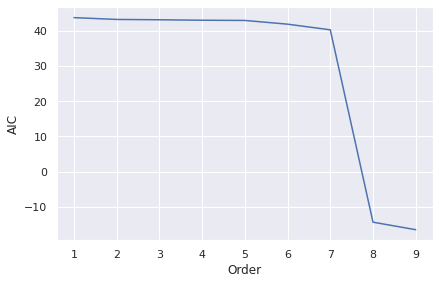

In [ ]:
train_size = int(0.85 * len(dae))

train = dae.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(dae.iloc[:train_size, 1:]), pd.DataFrame(dae.iloc[:train_size, 0])
x_test, y_test_dae = pd.DataFrame(dae.iloc[train_size:-7, 1:]), pd.DataFrame(dae.iloc[train_size:-7, 0])

forecasting_model = VAR(train)

results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
results = forecasting_model.fit(9)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Nov, 2021
Time:                     14:10:52
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -12.5695
Nobs:                     1464.00    HQIC:                  -15.0612
Log likelihood:          -9640.79    FPE:                6.55083e-08
AIC:                     -16.5434    Det(Omega_mle):     3.16697e-08
--------------------------------------------------------------------
Results for equation 1_week
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const             301.555637       171.786981            1.755           0.079
L1.1_week           0.407356         0.027258           14.945           0.000
L1.농산물            -10.271235         7.347676           -1.398     

In [ ]:
laaged_values = train.values[-9:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=len(y_test_dae)), index = y_test_dae.index)

y_pred_dae = forecast.iloc[:, 0]
y_pred_dae.head()

date
2020-01-13    1398.072440
2020-01-14    1231.281857
2020-01-15     997.590666
2020-01-16    1036.866334
2020-01-17    1068.661097
Name: 0, dtype: float64

## 얼갈이배추

결측치 처리

In [ ]:
ul = df[df['품목']=='얼갈이배추']
ul = ul.drop(['품목'], axis=1)
ul.isnull().sum()

1_week      0
농산물         0
가격          0
거래량         0
경유가격        0
dif_Temp    0
max_Temp    0
min_Temp    0
temp        0
wind        0
rain        0
dtype: int64

정상성 확인

In [ ]:
for col, item in ul.iteritems() :
  adfuller_test = adfuller(ul[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -4.792857909485917
p-value: 5.612294997138123e-05
농산물
ADF test statistic: -2.1287035587295784
p-value: 0.23313046089837702
가격
ADF test statistic: -3.734941555489577
p-value: 0.0036476679367053555
거래량
ADF test statistic: -3.564393575447993
p-value: 0.0064793889577664816
경유가격
ADF test statistic: -2.938657596362886
p-value: 0.04103379535073715
dif_Temp
ADF test statistic: -6.195141865190284
p-value: 5.99059448014576e-08
max_Temp
ADF test statistic: -2.8301679037168177
p-value: 0.054092035238827954
min_Temp
ADF test statistic: -2.8369598299665184
p-value: 0.05318518014919115
temp
ADF test statistic: -2.821848901272586
p-value: 0.05521994809800091
wind
ADF test statistic: -3.7068502334127302
p-value: 0.004017824755979362
rain
ADF test statistic: -8.73341934616746
p-value: 3.1467123821027994e-14


결론 : 농산물, max_Temp, min_Temp, temp 비정상성을 가짐 

차분

In [ ]:
lst = ['농산물',  'max_Temp', 'min_Temp', 'temp']
for col in lst:
  ul_diff = np.diff(ul[col])
  ul[col] = np.append([0], ul_diff)

for col, item in ul.iteritems() :
  adfuller_test = adfuller(ul[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -4.792857909485917
p-value: 5.612294997138123e-05
농산물
ADF test statistic: -41.60771758203591
p-value: 0.0
가격
ADF test statistic: -3.734941555489577
p-value: 0.0036476679367053555
거래량
ADF test statistic: -3.564393575447993
p-value: 0.0064793889577664816
경유가격
ADF test statistic: -2.938657596362886
p-value: 0.04103379535073715
dif_Temp
ADF test statistic: -6.195141865190284
p-value: 5.99059448014576e-08
max_Temp
ADF test statistic: -9.977627688272221
p-value: 2.1564889366319094e-17
min_Temp
ADF test statistic: -13.004010504457566
p-value: 2.6509380700816577e-24
temp
ADF test statistic: -8.452725532759278
p-value: 1.64572158179541e-13
wind
ADF test statistic: -3.7068502334127302
p-value: 0.004017824755979362
rain
ADF test statistic: -8.73341934616746
p-value: 3.1467123821027994e-14


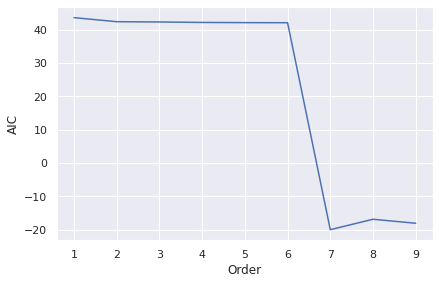

In [ ]:
train_size = int(0.85 * len(ul))

train = ul.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(ul.iloc[:train_size, 1:]), pd.DataFrame(ul.iloc[:train_size, 0])
x_test, y_test_ul = pd.DataFrame(ul.iloc[train_size:-7, 1:]), pd.DataFrame(ul.iloc[train_size:-7, 0])

forecasting_model = VAR(train)

results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
results = forecasting_model.fit(7)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Nov, 2021
Time:                     14:12:30
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -16.8752
Nobs:                     1466.00    HQIC:                  -18.8167
Log likelihood:          -7384.74    FPE:                2.12323e-09
AIC:                     -19.9714    Det(Omega_mle):     1.20047e-09
--------------------------------------------------------------------
Results for equation 1_week
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const             513.777657       142.804230            3.598           0.000
L1.1_week           0.452547         0.025517           17.735           0.000
L1.농산물            -10.626603         5.314891           -1.999     

In [ ]:
laaged_values = train.values[-7:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=len(y_test_ul)), index = y_test_ul.index)

y_pred_ul = forecast.iloc[:, 0]
y_pred_ul.head()

date
2020-01-13    1256.296130
2020-01-14    1094.784605
2020-01-15    1068.399293
2020-01-16    1152.672016
2020-01-17    1190.417588
Name: 0, dtype: float64

## 깻잎

결측치 처리

In [ ]:
ggaet = df[df['품목']=='깻잎']
ggaet = ggaet.drop(['품목'], axis=1)
ggaet.isnull().sum()

1_week      0
농산물         0
가격          0
거래량         0
경유가격        0
dif_Temp    0
max_Temp    0
min_Temp    0
temp        0
wind        0
rain        0
dtype: int64

정상성 확인

In [ ]:
for col, item in ggaet.iteritems() :
  adfuller_test = adfuller(ggaet[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -5.585419178850816
p-value: 1.366481482577105e-06
농산물
ADF test statistic: -2.1287035587295784
p-value: 0.23313046089837702
가격
ADF test statistic: -4.2468475832093455
p-value: 0.0005483880002137336
거래량
ADF test statistic: -3.174514684881853
p-value: 0.0215080798591413
경유가격
ADF test statistic: -3.083193660920752
p-value: 0.02782219257057328
dif_Temp
ADF test statistic: -6.104086611718888
p-value: 9.678357489582787e-08
max_Temp
ADF test statistic: -3.7782966856148086
p-value: 0.0031373394282818803
min_Temp
ADF test statistic: -2.8365015710838333
p-value: 0.05324597300976967
temp
ADF test statistic: -3.1141440347146805
p-value: 0.025524019924926217
wind
ADF test statistic: -17.548960751327602
p-value: 4.151977961331234e-30
rain
ADF test statistic: -8.522991522598309
p-value: 1.0879212663915307e-13


결론 : 농산물, min_Temp 비정상성을 가짐 

차분

In [ ]:
lst = ['농산물', 'min_Temp']
for col in lst:
  ggaet_diff = np.diff(ggaet[col])
  ggaet[col] = np.append([0], ggaet_diff)

for col, item in ggaet.iteritems() :
  adfuller_test = adfuller(ggaet[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -5.585419178850816
p-value: 1.366481482577105e-06
농산물
ADF test statistic: -41.60771758203591
p-value: 0.0
가격
ADF test statistic: -4.2468475832093455
p-value: 0.0005483880002137336
거래량
ADF test statistic: -3.174514684881853
p-value: 0.0215080798591413
경유가격
ADF test statistic: -3.083193660920752
p-value: 0.02782219257057328
dif_Temp
ADF test statistic: -6.104086611718888
p-value: 9.678357489582787e-08
max_Temp
ADF test statistic: -3.7782966856148086
p-value: 0.0031373394282818803
min_Temp
ADF test statistic: -13.654425041793546
p-value: 1.563565680778862e-25
temp
ADF test statistic: -3.1141440347146805
p-value: 0.025524019924926217
wind
ADF test statistic: -17.548960751327602
p-value: 4.151977961331234e-30
rain
ADF test statistic: -8.522991522598309
p-value: 1.0879212663915307e-13


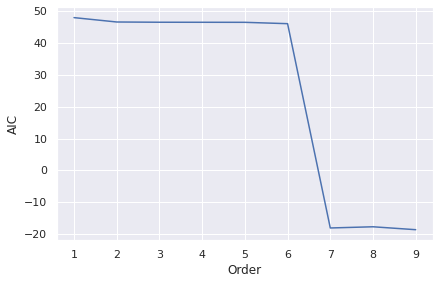

In [ ]:
train_size = int(0.85 * len(ggaet))

train = ggaet.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(ggaet.iloc[:train_size, 1:]), pd.DataFrame(ggaet.iloc[:train_size, 0])
x_test, y_test_ggaet = pd.DataFrame(ggaet.iloc[train_size:-7, 1:]), pd.DataFrame(ggaet.iloc[train_size:-7, 0])

forecasting_model = VAR(train)

results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
results = forecasting_model.fit(9)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Nov, 2021
Time:                     14:13:54
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -14.6914
Nobs:                     1464.00    HQIC:                  -17.1831
Log likelihood:          -8087.56    FPE:                7.84808e-09
AIC:                     -18.6653    Det(Omega_mle):     3.79412e-09
--------------------------------------------------------------------
Results for equation 1_week
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const            2970.751808       990.877507            2.998           0.003
L1.1_week           0.434293         0.026940           16.121           0.000
L1.농산물            -42.836685        32.574477           -1.315     

In [ ]:
laaged_values = train.values[-9:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=len(y_test_ggaet)), index = y_test_ggaet.index)

y_pred_ggaet = forecast.iloc[:, 0]
y_pred_ggaet.head()

date
2020-01-13    13606.750115
2020-01-14    12957.142442
2020-01-15    11820.875696
2020-01-16    11105.362625
2020-01-17    10270.874634
Name: 0, dtype: float64

## 시금치

결측치 처리

In [ ]:
si = df[df['품목']=='시금치']
si = si.drop(['품목'], axis=1)
si.isnull().sum()

1_week      0
농산물         0
가격          0
거래량         0
경유가격        0
dif_Temp    0
max_Temp    0
min_Temp    0
temp        0
wind        0
rain        0
dtype: int64

정상성 확인

In [ ]:
for col, item in si.iteritems() :
  adfuller_test = adfuller(si[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -5.452549742282608
p-value: 2.6246934990946003e-06
농산물
ADF test statistic: -2.1287035587295784
p-value: 0.23313046089837702
가격
ADF test statistic: -4.255757196362856
p-value: 0.0005294528098725136
거래량
ADF test statistic: -2.1776910823333417
p-value: 0.21444169994277745
경유가격
ADF test statistic: -2.938657596362886
p-value: 0.04103379535073715
dif_Temp
ADF test statistic: -6.195141865190284
p-value: 5.99059448014576e-08
max_Temp
ADF test statistic: -2.8301679037168177
p-value: 0.054092035238827954
min_Temp
ADF test statistic: -2.8369598299665184
p-value: 0.05318518014919115
temp
ADF test statistic: -2.821848901272586
p-value: 0.05521994809800091
wind
ADF test statistic: -3.7068502334127302
p-value: 0.004017824755979362
rain
ADF test statistic: -8.73341934616746
p-value: 3.1467123821027994e-14


결론 : 거래량, 농산물, max_Temp, min_Temp, temp 비정상성을 가짐 

차분

In [ ]:
lst = ['거래량', '농산물', 'max_Temp', 'min_Temp', 'temp']
for col in lst:
  si_diff = np.diff(si[col])
  si[col] = np.append([0], si_diff)

for col, item in si.iteritems() :
  adfuller_test = adfuller(si[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -5.452549742282608
p-value: 2.6246934990946003e-06
농산물
ADF test statistic: -41.60771758203591
p-value: 0.0
가격
ADF test statistic: -4.255757196362856
p-value: 0.0005294528098725136
거래량
ADF test statistic: -12.095411561864823
p-value: 2.0761088949328305e-22
경유가격
ADF test statistic: -2.938657596362886
p-value: 0.04103379535073715
dif_Temp
ADF test statistic: -6.195141865190284
p-value: 5.99059448014576e-08
max_Temp
ADF test statistic: -9.977627688272221
p-value: 2.1564889366319094e-17
min_Temp
ADF test statistic: -13.004010504457566
p-value: 2.6509380700816577e-24
temp
ADF test statistic: -8.452725532759278
p-value: 1.64572158179541e-13
wind
ADF test statistic: -3.7068502334127302
p-value: 0.004017824755979362
rain
ADF test statistic: -8.73341934616746
p-value: 3.1467123821027994e-14


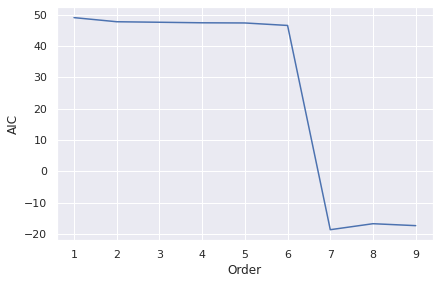

In [ ]:
train_size = int(0.85 * len(si))

train = si.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(si.iloc[:train_size, 1:]), pd.DataFrame(si.iloc[:train_size, 0])
x_test, y_test_si = pd.DataFrame(si.iloc[train_size:-7, 1:]), pd.DataFrame(si.iloc[train_size:-7, 0])

forecasting_model = VAR(train)

results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
results = forecasting_model.fit(7)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Nov, 2021
Time:                     14:15:29
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -15.5773
Nobs:                     1466.00    HQIC:                  -17.5187
Log likelihood:          -8336.11    FPE:                7.77451e-09
AIC:                     -18.6735    Det(Omega_mle):     4.39568e-09
--------------------------------------------------------------------
Results for equation 1_week
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const            1531.706638       514.981098            2.974           0.003
L1.1_week           0.405472         0.026661           15.208           0.000
L1.농산물              3.663948        19.521938            0.188     

In [ ]:
laaged_values = train.values[-7:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=len(y_test_si)), index = y_test_si.index)

y_pred_si = forecast.iloc[:, 0]
y_pred_si.head()

date
2020-01-13    3899.773780
2020-01-14    3060.745652
2020-01-15    2442.780477
2020-01-16    2916.180142
2020-01-17    3024.707390
Name: 0, dtype: float64

## 미나리

결측치 처리

In [ ]:
mi = df[df['품목']=='미나리']
mi = mi.drop(['품목'], axis=1)
mi.isnull().sum()

1_week      0
농산물         0
가격          0
거래량         0
경유가격        0
dif_Temp    0
max_Temp    0
min_Temp    0
temp        0
wind        0
rain        0
dtype: int64

정상성 확인

In [ ]:
for col, item in mi.iteritems() :
  adfuller_test = adfuller(mi[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -5.153717509852712
p-value: 1.0920790589794538e-05
농산물
ADF test statistic: -2.1287035587295784
p-value: 0.23313046089837702
가격
ADF test statistic: -4.614909318778561
p-value: 0.0001212384386135939
거래량
ADF test statistic: -4.6125379093109125
p-value: 0.00012246806945606726
경유가격
ADF test statistic: -2.938657596362886
p-value: 0.04103379535073715
dif_Temp
ADF test statistic: -6.195141865190284
p-value: 5.99059448014576e-08
max_Temp
ADF test statistic: -2.8301679037168177
p-value: 0.054092035238827954
min_Temp
ADF test statistic: -2.8369598299665184
p-value: 0.05318518014919115
temp
ADF test statistic: -2.821848901272586
p-value: 0.05521994809800091
wind
ADF test statistic: -3.7068502334127302
p-value: 0.004017824755979362
rain
ADF test statistic: -8.73341934616746
p-value: 3.1467123821027994e-14


결론 : 농산물, max_Temp, min_Temp, temp 비정상성을 가짐 

차분

In [ ]:
lst = ['농산물', 'max_Temp', 'min_Temp', 'temp']
for col in lst:
  mi_diff = np.diff(mi[col])
  mi[col] = np.append([0], mi_diff)

for col, item in mi.iteritems() :
  adfuller_test = adfuller(mi[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -5.153717509852712
p-value: 1.0920790589794538e-05
농산물
ADF test statistic: -41.60771758203591
p-value: 0.0
가격
ADF test statistic: -4.614909318778561
p-value: 0.0001212384386135939
거래량
ADF test statistic: -4.6125379093109125
p-value: 0.00012246806945606726
경유가격
ADF test statistic: -2.938657596362886
p-value: 0.04103379535073715
dif_Temp
ADF test statistic: -6.195141865190284
p-value: 5.99059448014576e-08
max_Temp
ADF test statistic: -9.977627688272221
p-value: 2.1564889366319094e-17
min_Temp
ADF test statistic: -13.004010504457566
p-value: 2.6509380700816577e-24
temp
ADF test statistic: -8.452725532759278
p-value: 1.64572158179541e-13
wind
ADF test statistic: -3.7068502334127302
p-value: 0.004017824755979362
rain
ADF test statistic: -8.73341934616746
p-value: 3.1467123821027994e-14


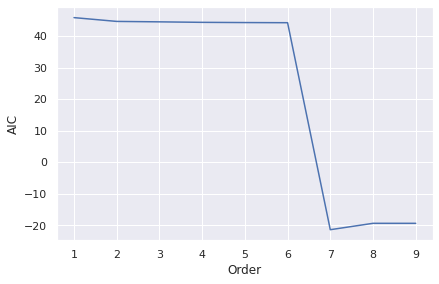

In [ ]:
train_size = int(0.85 * len(mi))

train = mi.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(mi.iloc[:train_size, 1:]), pd.DataFrame(mi.iloc[:train_size, 0])
x_test, y_test_mi = pd.DataFrame(mi.iloc[train_size:-7, 1:]), pd.DataFrame(mi.iloc[train_size:-7, 0])

forecasting_model = VAR(train)

results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
results = forecasting_model.fit(7)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Nov, 2021
Time:                     14:18:03
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -18.2899
Nobs:                     1466.00    HQIC:                  -20.2313
Log likelihood:          -6347.79    FPE:                5.15958e-10
AIC:                     -21.3861    Det(Omega_mle):     2.91721e-10
--------------------------------------------------------------------
Results for equation 1_week
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const             692.380441       448.466036            1.544           0.123
L1.1_week           0.561528         0.026194           21.437           0.000
L1.농산물            -16.666133        17.346226           -0.961     

In [ ]:
laaged_values = train.values[-7:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=len(y_test_mi)), index = y_test_mi.index)

y_pred_mi = forecast.iloc[:, 0]
y_pred_mi.head()

date
2020-01-13    3511.287754
2020-01-14    3515.330315
2020-01-15    3558.628050
2020-01-16    3419.768449
2020-01-17    4216.297840
Name: 0, dtype: float64

## 파프리카

결측치 처리

In [ ]:
pa = df[df['품목']=='파프리카']
pa = pa.drop(['품목'], axis=1)
pa.isnull().sum()

1_week      0
농산물         0
가격          0
거래량         0
경유가격        0
dif_Temp    0
max_Temp    0
min_Temp    0
temp        0
wind        0
rain        0
dtype: int64

정상성 확인

In [ ]:
for col, item in pa.iteritems() :
  adfuller_test = adfuller(pa[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -5.680422282933485
p-value: 8.511512160799071e-07
농산물
ADF test statistic: -2.1287035587295784
p-value: 0.23313046089837702
가격
ADF test statistic: -5.047197077620612
p-value: 1.7883595346727986e-05
거래량
ADF test statistic: -4.516442561541921
p-value: 0.00018361659085503013
경유가격
ADF test statistic: -2.792966186147177
p-value: 0.05928554389012386
dif_Temp
ADF test statistic: -5.17602422126443
p-value: 9.839033430657924e-06
max_Temp
ADF test statistic: -3.0678744345360722
p-value: 0.0290237911887327
min_Temp
ADF test statistic: -2.82693930661997
p-value: 0.05452752316873999
temp
ADF test statistic: -3.414311070495718
p-value: 0.01048057589766155
wind
ADF test statistic: -3.4212890634533895
p-value: 0.010254187298532945
rain
ADF test statistic: -13.015103150042048
p-value: 2.520588954814821e-24


결론 : 경유가격, 농산물, min_Temp 비정상성을 가짐 

차분

In [ ]:
lst = ['경유가격', '농산물', 'min_Temp']
for col in lst:
  pa_diff = np.diff(pa[col])
  pa[col] = np.append([0], pa_diff)

for col, item in pa.iteritems() :
  adfuller_test = adfuller(pa[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -5.680422282933485
p-value: 8.511512160799071e-07
농산물
ADF test statistic: -41.60771758203591
p-value: 0.0
가격
ADF test statistic: -5.047197077620612
p-value: 1.7883595346727986e-05
거래량
ADF test statistic: -4.516442561541921
p-value: 0.00018361659085503013
경유가격
ADF test statistic: -4.681929927868882
p-value: 9.098219339401736e-05
dif_Temp
ADF test statistic: -5.17602422126443
p-value: 9.839033430657924e-06
max_Temp
ADF test statistic: -3.0678744345360722
p-value: 0.0290237911887327
min_Temp
ADF test statistic: -12.241210078956705
p-value: 1.0015898111231977e-22
temp
ADF test statistic: -3.414311070495718
p-value: 0.01048057589766155
wind
ADF test statistic: -3.4212890634533895
p-value: 0.010254187298532945
rain
ADF test statistic: -13.015103150042048
p-value: 2.520588954814821e-24


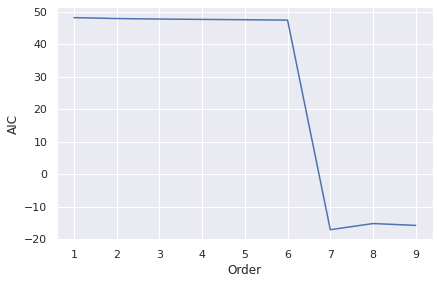

In [ ]:
train_size = int(0.85 * len(pa))

train = pa.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(pa.iloc[:train_size, 1:]), pd.DataFrame(pa.iloc[:train_size, 0])
x_test, y_test_pa = pd.DataFrame(pa.iloc[train_size:-7, 1:]), pd.DataFrame(pa.iloc[train_size:-7, 0])

forecasting_model = VAR(train)

results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
results = forecasting_model.fit(7)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Nov, 2021
Time:                     14:19:29
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -13.9655
Nobs:                     1466.00    HQIC:                  -15.9069
Log likelihood:          -9517.55    FPE:                3.89641e-08
AIC:                     -17.0617    Det(Omega_mle):     2.20302e-08
--------------------------------------------------------------------
Results for equation 1_week
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const            1646.931600       433.116030            3.803           0.000
L1.1_week           0.466272         0.026287           17.738           0.000
L1.농산물              6.604122        21.297263            0.310     

In [ ]:
laaged_values = train.values[-7:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=len(y_test_pa)), index = y_test_pa.index)

y_pred_pa = forecast.iloc[:, 0]
y_pred_pa.head()

date
2020-01-13    4885.850775
2020-01-14    5365.859876
2020-01-15    5633.868417
2020-01-16    5434.814023
2020-01-17    5066.455410
Name: 0, dtype: float64

## 새송이

결측치 처리

In [ ]:
sae = df[df['품목']=='새송이']
sae = sae.drop(['품목'], axis=1)
sae.isnull().sum()

1_week      0
농산물         0
가격          0
거래량         0
경유가격        0
dif_Temp    0
max_Temp    0
min_Temp    0
temp        0
wind        0
rain        0
dtype: int64

정상성 확인

In [ ]:
for col, item in sae.iteritems() :
  adfuller_test = adfuller(sae[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -6.213816187552035
p-value: 5.42655219377619e-08
농산물
ADF test statistic: -2.1287035587295784
p-value: 0.23313046089837702
가격
ADF test statistic: -5.829736039387242
p-value: 4.001133542699277e-07
거래량
ADF test statistic: -6.9212481079952655
p-value: 1.144980221345938e-09
경유가격
ADF test statistic: -2.823431030903555
p-value: 0.055003974588095104
dif_Temp
ADF test statistic: -6.401146887529275
p-value: 1.9941074473208714e-08
max_Temp
ADF test statistic: -2.840198870178088
p-value: 0.052757104322291866
min_Temp
ADF test statistic: -3.5941742892414195
p-value: 0.005873384540098733
temp
ADF test statistic: -3.454296170490838
p-value: 0.009241439623793563
wind
ADF test statistic: -3.1958268216998285
p-value: 0.020227513512593696
rain
ADF test statistic: -6.843204862746117
p-value: 1.769549476543645e-09


결론 : 경유가격, 농산물, max_Temp 비정상성을 가짐



차분

In [ ]:
lst = ['경유가격', '농산물', 'max_Temp']
for col in lst:
  sae_diff = np.diff(sae[col])
  sae[col] = np.append([0], sae_diff)

for col, item in sae.iteritems() :
  adfuller_test = adfuller(sae[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -6.213816187552035
p-value: 5.42655219377619e-08
농산물
ADF test statistic: -41.60771758203591
p-value: 0.0
가격
ADF test statistic: -5.829736039387242
p-value: 4.001133542699277e-07
거래량
ADF test statistic: -6.9212481079952655
p-value: 1.144980221345938e-09
경유가격
ADF test statistic: -4.895712112037314
p-value: 3.555081308482447e-05
dif_Temp
ADF test statistic: -6.401146887529275
p-value: 1.9941074473208714e-08
max_Temp
ADF test statistic: -10.234524237043159
p-value: 4.928950294317126e-18
min_Temp
ADF test statistic: -3.5941742892414195
p-value: 0.005873384540098733
temp
ADF test statistic: -3.454296170490838
p-value: 0.009241439623793563
wind
ADF test statistic: -3.1958268216998285
p-value: 0.020227513512593696
rain
ADF test statistic: -6.843204862746117
p-value: 1.769549476543645e-09


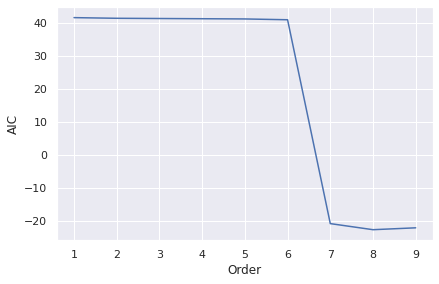

In [ ]:
train_size = int(0.85 * len(sae))

train = sae.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(sae.iloc[:train_size, 1:]), pd.DataFrame(sae.iloc[:train_size, 0])
x_test, y_test_sae = pd.DataFrame(sae.iloc[train_size:-7, 1:]), pd.DataFrame(sae.iloc[train_size:-7, 0])

forecasting_model = VAR(train)

results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
results = forecasting_model.fit(8)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Nov, 2021
Time:                     14:21:07
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -19.1020
Nobs:                     1465.00    HQIC:                  -21.3184
Log likelihood:          -5305.74    FPE:                1.47801e-10
AIC:                     -22.6368    Det(Omega_mle):     7.72556e-11
--------------------------------------------------------------------
Results for equation 1_week
                 coefficient            std. error           t-stat            prob
-----------------------------------------------------------------------------------
const             874.479718            232.735005            3.757           0.000
L1.1_week           0.429548              0.026778           16.041           0.000
L1.농산물            -10.139116             10.436

In [ ]:
laaged_values = train.values[-8:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=len(y_test_sae)), index = y_test_sae.index)

y_pred_sae = forecast.iloc[:, 0]
y_pred_sae.head()

date
2020-01-13    3985.637825
2020-01-14    3193.394314
2020-01-15    2577.543053
2020-01-16    2568.440267
2020-01-17    2746.416458
Name: 0, dtype: float64

## 팽이버섯

결측치 처리

In [ ]:
paeng = df[df['품목']=='팽이버섯']
paeng = paeng.drop(['품목'], axis=1)
paeng.isnull().sum()

1_week      0
농산물         0
가격          0
거래량         0
경유가격        0
dif_Temp    0
max_Temp    0
min_Temp    0
temp        0
wind        0
rain        0
dtype: int64

정상성 확인

In [ ]:
for col, item in paeng.iteritems() :
  adfuller_test = adfuller(paeng[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -4.0123651621385585
p-value: 0.0013471298311210755
농산물
ADF test statistic: -2.1287035587295784
p-value: 0.23313046089837702
가격
ADF test statistic: -4.029138215141592
p-value: 0.0012653899438269196
거래량
ADF test statistic: -4.968784582781522
p-value: 2.557645659668349e-05
경유가격
ADF test statistic: -2.999122224676903
p-value: 0.03497645479827025
dif_Temp
ADF test statistic: -9.062023358445131
p-value: 4.536107647971637e-15
max_Temp
ADF test statistic: -2.8226734922861554
p-value: 0.05510729865347643
min_Temp
ADF test statistic: -3.6778297015910235
p-value: 0.004436029618618376
temp
ADF test statistic: -3.5125676827713175
p-value: 0.007670135056495546
wind
ADF test statistic: -4.589394821625606
p-value: 0.00013510997402628534
rain
ADF test statistic: -7.719652346289554
p-value: 1.2020933087343618e-11


결론 : 농산물, max_Temp 비정상성을 가짐 

차분

In [ ]:
lst = ['농산물', 'max_Temp']
for col in lst:
  paeng_diff = np.diff(paeng[col])
  paeng[col] = np.append([0], paeng_diff)

for col, item in paeng.iteritems() :
  adfuller_test = adfuller(paeng[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -4.0123651621385585
p-value: 0.0013471298311210755
농산물
ADF test statistic: -41.60771758203591
p-value: 0.0
가격
ADF test statistic: -4.029138215141592
p-value: 0.0012653899438269196
거래량
ADF test statistic: -4.968784582781522
p-value: 2.557645659668349e-05
경유가격
ADF test statistic: -2.999122224676903
p-value: 0.03497645479827025
dif_Temp
ADF test statistic: -9.062023358445131
p-value: 4.536107647971637e-15
max_Temp
ADF test statistic: -15.774029219110808
p-value: 1.151911953093931e-28
min_Temp
ADF test statistic: -3.6778297015910235
p-value: 0.004436029618618376
temp
ADF test statistic: -3.5125676827713175
p-value: 0.007670135056495546
wind
ADF test statistic: -4.589394821625606
p-value: 0.00013510997402628534
rain
ADF test statistic: -7.719652346289554
p-value: 1.2020933087343618e-11


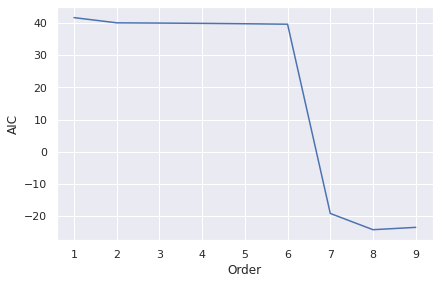

In [ ]:
train_size = int(0.85 * len(paeng))

train = paeng.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(paeng.iloc[:train_size, 1:]), pd.DataFrame(paeng.iloc[:train_size, 0])
x_test, y_test_paeng = pd.DataFrame(paeng.iloc[train_size:-7, 1:]), pd.DataFrame(paeng.iloc[train_size:-7, 0])

forecasting_model = VAR(train)

results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
results = forecasting_model.fit(8)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Nov, 2021
Time:                     14:22:15
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -20.6990
Nobs:                     1465.00    HQIC:                  -22.9155
Log likelihood:          -4135.89    FPE:                2.99282e-11
AIC:                     -24.2339    Det(Omega_mle):     1.56435e-11
--------------------------------------------------------------------
Results for equation 1_week
                 coefficient           std. error           t-stat            prob
----------------------------------------------------------------------------------
const             149.841525           264.394985            0.567           0.571
L1.1_week           0.417525             0.026352           15.844           0.000
L1.농산물            -12.240297             8.902640  

In [ ]:
laaged_values = train.values[-8:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=len(y_test_paeng)), index = y_test_paeng.index)

y_pred_paeng = forecast.iloc[:, 0]
y_pred_paeng.head()

date
2020-01-13    3097.153354
2020-01-14    2932.771056
2020-01-15    2883.204681
2020-01-16    2844.778763
2020-01-17    2988.316311
Name: 0, dtype: float64

## 토마토

결측치 처리

In [ ]:
to = df[df['품목']=='토마토']
to = to.drop(['품목'], axis=1)
to.isnull().sum()

1_week      0
농산물         0
가격          0
거래량         0
경유가격        0
dif_Temp    0
max_Temp    0
min_Temp    0
temp        0
wind        0
rain        0
dtype: int64

정상성 확인

In [ ]:
for col, item in to.iteritems() :
  adfuller_test = adfuller(to[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -4.54209598170263
p-value: 0.00016492405087652938
농산물
ADF test statistic: -2.1287035587295784
p-value: 0.23313046089837702
가격
ADF test statistic: -3.213009770474986
p-value: 0.01924386544699542
거래량
ADF test statistic: -3.0952982778409486
p-value: 0.026903099278297902
경유가격
ADF test statistic: -3.0268652446137003
p-value: 0.03246055747817326
dif_Temp
ADF test statistic: -5.882134549664304
p-value: 3.0607540250617614e-07
max_Temp
ADF test statistic: -3.0370066041538917
p-value: 0.031580014679529866
min_Temp
ADF test statistic: -2.4801179293367515
p-value: 0.12038709242728873
temp
ADF test statistic: -4.058524358392686
p-value: 0.001133234137631344
wind
ADF test statistic: -12.977246485940283
p-value: 2.994757754665951e-24
rain
ADF test statistic: -10.314757122961039
p-value: 3.1182194489326246e-18


결론 : 농산물, min_Temp 비정상성을 가짐 

차분

In [ ]:
lst = ['농산물', 'min_Temp']
for col in lst:
  to_diff = np.diff(to[col])
  to[col] = np.append([0], to_diff)

for col, item in to.iteritems() :
  adfuller_test = adfuller(to[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -4.54209598170263
p-value: 0.00016492405087652938
농산물
ADF test statistic: -41.60771758203591
p-value: 0.0
가격
ADF test statistic: -3.213009770474986
p-value: 0.01924386544699542
거래량
ADF test statistic: -3.0952982778409486
p-value: 0.026903099278297902
경유가격
ADF test statistic: -3.0268652446137003
p-value: 0.03246055747817326
dif_Temp
ADF test statistic: -5.882134549664304
p-value: 3.0607540250617614e-07
max_Temp
ADF test statistic: -3.0370066041538917
p-value: 0.031580014679529866
min_Temp
ADF test statistic: -11.749529111348494
p-value: 1.2185449298004651e-21
temp
ADF test statistic: -4.058524358392686
p-value: 0.001133234137631344
wind
ADF test statistic: -12.977246485940283
p-value: 2.994757754665951e-24
rain
ADF test statistic: -10.314757122961039
p-value: 3.1182194489326246e-18


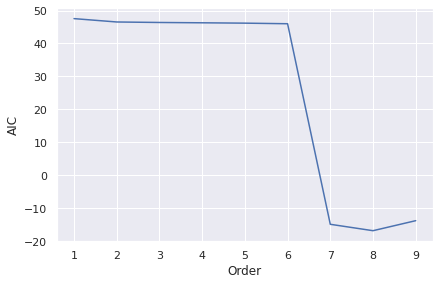

In [ ]:
train_size = int(0.85 * len(to))

train = to.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(to.iloc[:train_size, 1:]), pd.DataFrame(to.iloc[:train_size, 0])
x_test, y_test_to = pd.DataFrame(to.iloc[train_size:-7, 1:]), pd.DataFrame(to.iloc[train_size:-7, 0])

forecasting_model = VAR(train)

results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
results = forecasting_model.fit(8)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Nov, 2021
Time:                     14:23:27
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -13.3470
Nobs:                     1465.00    HQIC:                  -15.5634
Log likelihood:          -9521.23    FPE:                4.66679e-08
AIC:                     -16.8819    Det(Omega_mle):     2.43933e-08
--------------------------------------------------------------------
Results for equation 1_week
                 coefficient          std. error           t-stat            prob
---------------------------------------------------------------------------------
const             429.069232          287.169291            1.494           0.135
L1.1_week           0.467820            0.027070           17.282           0.000
L1.농산물            -10.572462           10.300028       

In [ ]:
laaged_values = train.values[-8:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=len(y_test_to)), index = y_test_to.index)

y_pred_to = forecast.iloc[:, 0]
y_pred_to.head()

date
2020-01-13    4395.611094
2020-01-14    3933.643220
2020-01-15    3489.442945
2020-01-16    3561.012592
2020-01-17    3184.913366
Name: 0, dtype: float64

## 청상추

결측치 처리

In [ ]:
cheong = df[df['품목']=='청상추']
cheong = cheong.drop(['품목'], axis=1)
cheong.isnull().sum()

1_week      0
농산물         0
가격          0
거래량         0
경유가격        0
dif_Temp    0
max_Temp    0
min_Temp    0
temp        0
wind        0
rain        0
dtype: int64

정상성 확인

In [ ]:
for col, item in cheong.iteritems() :
  adfuller_test = adfuller(cheong[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -5.107615509737243
p-value: 1.353301758755656e-05
농산물
ADF test statistic: -2.1287035587295784
p-value: 0.23313046089837702
가격
ADF test statistic: -4.938491259451649
p-value: 2.9331837204761955e-05
거래량
ADF test statistic: -3.822978503521799
p-value: 0.0026807732582546603
경유가격
ADF test statistic: -2.778481505090953
p-value: 0.06141388172149969
dif_Temp
ADF test statistic: -5.726301372998177
p-value: 6.758927363021723e-07
max_Temp
ADF test statistic: -3.29585078023174
p-value: 0.015064966556945355
min_Temp
ADF test statistic: -3.6786803426892787
p-value: 0.004423226371712541
temp
ADF test statistic: -2.7270607281184005
p-value: 0.0694714943442352
wind
ADF test statistic: -5.406066935960674
p-value: 3.289224541877864e-06
rain
ADF test statistic: -5.623918982835204
p-value: 1.1286847315377788e-06


결론 : 경유가격, 농산물, temp 비정상성을 가짐 

차분

In [ ]:
lst = ['경유가격', '농산물', 'temp']
for col in lst:
  cheong_diff = np.diff(cheong[col])
  cheong[col] = np.append([0], cheong_diff)

for col, item in cheong.iteritems() :
  adfuller_test = adfuller(cheong[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -5.107615509737243
p-value: 1.353301758755656e-05
농산물
ADF test statistic: -41.60771758203591
p-value: 0.0
가격
ADF test statistic: -4.938491259451649
p-value: 2.9331837204761955e-05
거래량
ADF test statistic: -3.822978503521799
p-value: 0.0026807732582546603
경유가격
ADF test statistic: -5.059402308677777
p-value: 1.6907987485805067e-05
dif_Temp
ADF test statistic: -5.726301372998177
p-value: 6.758927363021723e-07
max_Temp
ADF test statistic: -3.29585078023174
p-value: 0.015064966556945355
min_Temp
ADF test statistic: -3.6786803426892787
p-value: 0.004423226371712541
temp
ADF test statistic: -8.99767693985718
p-value: 6.626558085031198e-15
wind
ADF test statistic: -5.406066935960674
p-value: 3.289224541877864e-06
rain
ADF test statistic: -5.623918982835204
p-value: 1.1286847315377788e-06


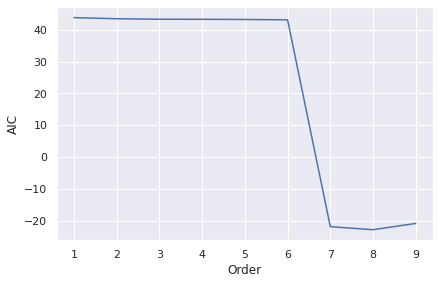

In [ ]:
train_size = int(0.85 * len(cheong))

train = cheong.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(cheong.iloc[:train_size, 1:]), pd.DataFrame(cheong.iloc[:train_size, 0])
x_test, y_test_cheong = pd.DataFrame(cheong.iloc[train_size:-7, 1:]), pd.DataFrame(cheong.iloc[train_size:-7, 0])

forecasting_model = VAR(train)

results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
results = forecasting_model.fit(8)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Nov, 2021
Time:                     14:24:58
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -19.3500
Nobs:                     1465.00    HQIC:                  -21.5664
Log likelihood:          -5124.08    FPE:                1.15339e-10
AIC:                     -22.8848    Det(Omega_mle):     6.02875e-11
--------------------------------------------------------------------
Results for equation 1_week
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const            2379.009026       709.632107            3.352           0.001
L1.1_week           0.472725         0.027313           17.308           0.000
L1.농산물            -36.043333        26.353222           -1.368     

In [ ]:
laaged_values = train.values[-8:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=len(y_test_cheong)), index = y_test_cheong.index)

y_pred_cheong = forecast.iloc[:, 0]
y_pred_cheong.head()

date
2020-01-13    8890.399835
2020-01-14    7417.144705
2020-01-15    6900.840164
2020-01-16    6335.115384
2020-01-17    5703.909456
Name: 0, dtype: float64

## 백다다기

결측치 처리

In [ ]:
baek = df[df['품목']=='백다다기']
baek = baek.drop(['품목'], axis=1)
baek.isnull().sum()

1_week      0
농산물         0
가격          0
거래량         0
경유가격        0
dif_Temp    0
max_Temp    0
min_Temp    0
temp        0
wind        0
rain        0
dtype: int64

정상성 확인

In [ ]:
for col, item in baek.iteritems() :
  adfuller_test = adfuller(baek[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -4.752154754215
p-value: 6.708449545172626e-05
농산물
ADF test statistic: -2.1287035587295784
p-value: 0.23313046089837702
가격
ADF test statistic: -3.8263096530475886
p-value: 0.002649316721906204
거래량
ADF test statistic: -3.1073005184936635
p-value: 0.02601761369740233
경유가격
ADF test statistic: -2.823431030903555
p-value: 0.055003974588095104
dif_Temp
ADF test statistic: -6.401146887529275
p-value: 1.9941074473208714e-08
max_Temp
ADF test statistic: -2.840198870178088
p-value: 0.052757104322291866
min_Temp
ADF test statistic: -3.5941742892414195
p-value: 0.005873384540098733
temp
ADF test statistic: -3.454296170490838
p-value: 0.009241439623793563
wind
ADF test statistic: -3.1958268216998285
p-value: 0.020227513512593696
rain
ADF test statistic: -6.843204862746117
p-value: 1.769549476543645e-09


결론 : 경유가격, 농산물, max_Temp 비정상성을 가짐 

차분

In [ ]:
lst = ['경유가격', '농산물', 'max_Temp']
for col in lst:
  baek_diff = np.diff(baek[col])
  baek[col] = np.append([0], baek_diff)

for col, item in baek.iteritems() :
  adfuller_test = adfuller(baek[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -4.752154754215
p-value: 6.708449545172626e-05
농산물
ADF test statistic: -41.60771758203591
p-value: 0.0
가격
ADF test statistic: -3.8263096530475886
p-value: 0.002649316721906204
거래량
ADF test statistic: -3.1073005184936635
p-value: 0.02601761369740233
경유가격
ADF test statistic: -4.895712112037314
p-value: 3.555081308482447e-05
dif_Temp
ADF test statistic: -6.401146887529275
p-value: 1.9941074473208714e-08
max_Temp
ADF test statistic: -10.234524237043159
p-value: 4.928950294317126e-18
min_Temp
ADF test statistic: -3.5941742892414195
p-value: 0.005873384540098733
temp
ADF test statistic: -3.454296170490838
p-value: 0.009241439623793563
wind
ADF test statistic: -3.1958268216998285
p-value: 0.020227513512593696
rain
ADF test statistic: -6.843204862746117
p-value: 1.769549476543645e-09


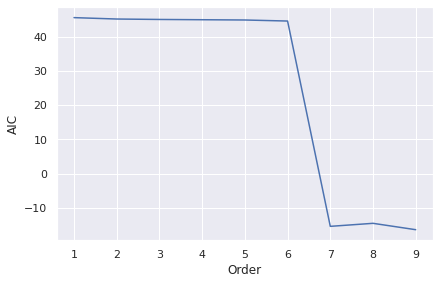

In [ ]:
train_size = int(0.85 * len(baek))

train = baek.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(baek.iloc[:train_size, 1:]), pd.DataFrame(baek.iloc[:train_size, 0])
x_test, y_test_baek = pd.DataFrame(baek.iloc[train_size:-7, 1:]), pd.DataFrame(baek.iloc[train_size:-7, 0])

forecasting_model = VAR(train)

results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
results = forecasting_model.fit(9)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Nov, 2021
Time:                     14:26:12
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -12.3206
Nobs:                     1464.00    HQIC:                  -14.8123
Log likelihood:          -9822.98    FPE:                8.40206e-08
AIC:                     -16.2945    Det(Omega_mle):     4.06194e-08
--------------------------------------------------------------------
Results for equation 1_week
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const            1339.430298       226.104113            5.924           0.000
L1.1_week           0.493339         0.027209           18.132           0.000
L1.농산물            -12.866854        10.579742           -1.216     

In [ ]:
laaged_values = train.values[-9:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=len(y_test_baek)), index = y_test_baek.index)

y_pred_baek = forecast.iloc[:, 0]
y_pred_baek.head()

date
2020-01-13    3422.371725
2020-01-14    2938.082338
2020-01-15    2862.665332
2020-01-16    2673.917059
2020-01-17    2831.472406
Name: 0, dtype: float64

## 애호박

결측치 처리

In [ ]:
ae = df[df['품목']=='애호박']
ae = ae.drop(['품목'], axis=1)
ae.isnull().sum()

1_week      0
농산물         0
가격          0
거래량         0
경유가격        0
dif_Temp    0
max_Temp    0
min_Temp    0
temp        0
wind        0
rain        0
dtype: int64

정상성 확인

In [ ]:
for col, item in ae.iteritems() :
  adfuller_test = adfuller(ae[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -5.179854278348307
p-value: 9.664042824583585e-06
농산물
ADF test statistic: -2.1287035587295784
p-value: 0.23313046089837702
가격
ADF test statistic: -4.571102842120049
p-value: 0.00014597311220436085
거래량
ADF test statistic: -3.9362354487688083
p-value: 0.0017837805122591123
경유가격
ADF test statistic: -3.083193660920752
p-value: 0.02782219257057328
dif_Temp
ADF test statistic: -6.104086611718888
p-value: 9.678357489582787e-08
max_Temp
ADF test statistic: -3.7782966856148086
p-value: 0.0031373394282818803
min_Temp
ADF test statistic: -2.8365015710838333
p-value: 0.05324597300976967
temp
ADF test statistic: -3.1141440347146805
p-value: 0.025524019924926217
wind
ADF test statistic: -17.548960751327602
p-value: 4.151977961331234e-30
rain
ADF test statistic: -8.522991522598309
p-value: 1.0879212663915307e-13


결론 : 농산물, min_Temp 비정상성을 가짐 

차분

In [ ]:
lst = ['농산물', 'min_Temp']
for col in lst:
  ae_diff = np.diff(ae[col])
  ae[col] = np.append([0], ae_diff)

for col, item in ae.iteritems() :
  adfuller_test = adfuller(ae[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -5.179854278348307
p-value: 9.664042824583585e-06
농산물
ADF test statistic: -41.60771758203591
p-value: 0.0
가격
ADF test statistic: -4.571102842120049
p-value: 0.00014597311220436085
거래량
ADF test statistic: -3.9362354487688083
p-value: 0.0017837805122591123
경유가격
ADF test statistic: -3.083193660920752
p-value: 0.02782219257057328
dif_Temp
ADF test statistic: -6.104086611718888
p-value: 9.678357489582787e-08
max_Temp
ADF test statistic: -3.7782966856148086
p-value: 0.0031373394282818803
min_Temp
ADF test statistic: -13.654425041793546
p-value: 1.563565680778862e-25
temp
ADF test statistic: -3.1141440347146805
p-value: 0.025524019924926217
wind
ADF test statistic: -17.548960751327602
p-value: 4.151977961331234e-30
rain
ADF test statistic: -8.522991522598309
p-value: 1.0879212663915307e-13


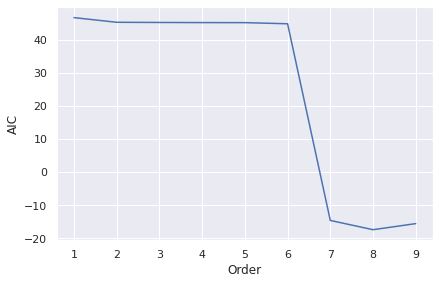

In [ ]:
train_size = int(0.85 * len(ae))

train = ae.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(ae.iloc[:train_size, 1:]), pd.DataFrame(ae.iloc[:train_size, 0])
x_test, y_test_ae = pd.DataFrame(ae.iloc[train_size:-7, 1:]), pd.DataFrame(ae.iloc[train_size:-7, 0])

forecasting_model = VAR(train)

results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
results = forecasting_model.fit(8)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Nov, 2021
Time:                     14:27:19
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -13.8138
Nobs:                     1465.00    HQIC:                  -16.0302
Log likelihood:          -9179.31    FPE:                2.92614e-08
AIC:                     -17.3486    Det(Omega_mle):     1.52949e-08
--------------------------------------------------------------------
Results for equation 1_week
                 coefficient           std. error           t-stat            prob
----------------------------------------------------------------------------------
const             943.034442           324.142204            2.909           0.004
L1.1_week           0.570773             0.026796           21.301           0.000
L1.농산물            -11.471213            11.027701  

In [ ]:
laaged_values = train.values[-8:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=len(y_test_ae)), index = y_test_ae.index)

y_pred_ae = forecast.iloc[:, 0]
y_pred_ae.head()

date
2020-01-13    4871.094085
2020-01-14    4135.927136
2020-01-15    4144.509453
2020-01-16    3661.136563
2020-01-17    3307.460916
Name: 0, dtype: float64

## 캠벨얼리

결측치 처리

In [ ]:
caem = df[df['품목']=='캠벨얼리']
caem = caem.drop(['품목'], axis=1)
ae.isnull().sum()

1_week      0
농산물         0
가격          0
거래량         0
경유가격        0
dif_Temp    0
max_Temp    0
min_Temp    0
temp        0
wind        0
rain        0
dtype: int64

정상성 확인

In [ ]:
for col, item in caem.iteritems() :
  adfuller_test = adfuller(caem[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -3.8163718541885663
p-value: 0.002744181709027031
농산물
ADF test statistic: -2.1287035587295784
p-value: 0.23313046089837702
가격
ADF test statistic: -3.910154202980666
p-value: 0.001961375718609109
거래량
ADF test statistic: -4.825249597049801
p-value: 4.8649340230883656e-05
경유가격
ADF test statistic: -2.999122224676903
p-value: 0.03497645479827025
dif_Temp
ADF test statistic: -9.062023358445131
p-value: 4.536107647971637e-15
max_Temp
ADF test statistic: -2.8226734922861554
p-value: 0.05510729865347643
min_Temp
ADF test statistic: -3.6778297015910235
p-value: 0.004436029618618376
temp
ADF test statistic: -3.5125676827713175
p-value: 0.007670135056495546
wind
ADF test statistic: -4.589394821625606
p-value: 0.00013510997402628534
rain
ADF test statistic: -7.719652346289554
p-value: 1.2020933087343618e-11


결론 : 농산물, max_Temp 비정상성을 가짐 

차분

In [ ]:
lst = ['농산물', 'max_Temp']
for col in lst:
  caem_diff = np.diff(caem[col])
  caem[col] = np.append([0], caem_diff)

for col, item in caem.iteritems() :
  adfuller_test = adfuller(caem[col], autolag= 'AIC')
  print(col)
  print('ADF test statistic: {}'.format(adfuller_test[0]))
  print('p-value: {}'.format(adfuller_test[1]))

1_week
ADF test statistic: -3.8163718541885663
p-value: 0.002744181709027031
농산물
ADF test statistic: -41.60771758203591
p-value: 0.0
가격
ADF test statistic: -3.910154202980666
p-value: 0.001961375718609109
거래량
ADF test statistic: -4.825249597049801
p-value: 4.8649340230883656e-05
경유가격
ADF test statistic: -2.999122224676903
p-value: 0.03497645479827025
dif_Temp
ADF test statistic: -9.062023358445131
p-value: 4.536107647971637e-15
max_Temp
ADF test statistic: -15.774029219110808
p-value: 1.151911953093931e-28
min_Temp
ADF test statistic: -3.6778297015910235
p-value: 0.004436029618618376
temp
ADF test statistic: -3.5125676827713175
p-value: 0.007670135056495546
wind
ADF test statistic: -4.589394821625606
p-value: 0.00013510997402628534
rain
ADF test statistic: -7.719652346289554
p-value: 1.2020933087343618e-11


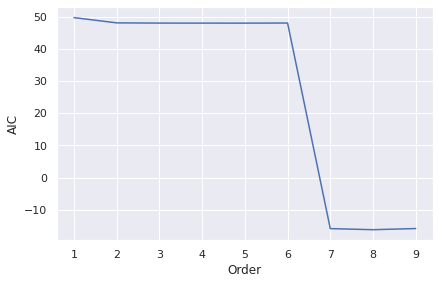

In [ ]:
train_size = int(0.85 * len(caem))

train = caem.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(caem.iloc[:train_size, 1:]), pd.DataFrame(caem.iloc[:train_size, 0])
x_test, y_test_caem = pd.DataFrame(caem.iloc[train_size:-7, 1:]), pd.DataFrame(caem.iloc[train_size:-7, 0])

forecasting_model = VAR(train)

results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
results = forecasting_model.fit(8)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Nov, 2021
Time:                     14:28:31
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -12.6702
Nobs:                     1465.00    HQIC:                  -14.8867
Log likelihood:          -10017.0    FPE:                9.18214e-08
AIC:                     -16.2051    Det(Omega_mle):     4.79951e-08
--------------------------------------------------------------------
Results for equation 1_week
                 coefficient            std. error           t-stat            prob
-----------------------------------------------------------------------------------
const           -1313.413019            794.271455           -1.654           0.098
L1.1_week           0.122585              0.050721            2.417           0.016
L1.농산물            -20.750732             31.691

In [ ]:
laaged_values = train.values[-8:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=len(y_test_caem)), index = y_test_caem.index)

y_pred_caem = forecast.iloc[:, 0]
y_pred_caem.head()

date
2020-01-13    6031.865458
2020-01-14    1122.193371
2020-01-15    7614.174777
2020-01-16    4141.906898
2020-01-17    6028.539284
Name: 0, dtype: float64

# 성능평가

In [ ]:
answer_df = pd.concat([y_test_bae, y_test_yang, y_test_gun, y_test_ma, y_test_dae, y_test_ul, y_test_ggaet, y_test_si, y_test_mi, y_test_pa, y_test_sae, y_test_paeng,
                       y_test_to, y_test_cheong, y_test_baek, y_test_ae, y_test_caem], axis=1)
answer_df.columns = ['배추', '양파', '건고추', '마늘', '대파', '얼갈이배추', '깻잎', '시금치', '미나리', '파프리카', '새송이', '팽이버섯', '토마토', '청상추', '백다다기', '애호박', '캠벨얼리']
answer_df.head()
#answer_df.to_csv('/content/drive/MyDrive/answer.csv')

,배추,양파,건고추,마늘,대파,얼갈이배추,깻잎,시금치,미나리,파프리카,새송이,팽이버섯,토마토,청상추,백다다기,애호박,캠벨얼리
date,,,,,,,,,,,,,,,,,
2020-01-13,754.0,826.0,7251.0,2697.0,890.0,1339.0,14326.0,2411.0,5762.0,6719.0,2956.0,3912.0,2796.0,6568.0,4696.0,3866.0,3893.0
2020-01-14,716.0,842.0,11843.0,2936.0,986.0,1198.0,13416.0,2324.0,6440.0,6935.0,3052.0,3951.0,2793.0,6029.0,4860.0,3701.0,7719.0
2020-01-15,741.0,879.0,8379.0,2873.0,999.0,1197.0,13428.0,2513.0,7506.0,6513.0,3241.0,3398.0,2866.0,6584.0,5294.0,3757.0,8911.0
2020-01-16,770.0,852.0,12607.0,2992.0,942.0,1035.0,13322.0,2476.0,7100.0,6137.0,3154.0,3081.0,2305.0,5217.0,4598.0,3390.0,5854.0
2020-01-17,659.0,636.0,0.0,2955.0,739.0,768.0,7081.0,1430.0,2636.0,5223.0,2139.0,2247.0,2055.0,2783.0,2758.0,2727.0,4676.0


In [ ]:
submission_df = pd.concat([y_pred_bae, y_pred_yang, y_pred_gun, y_pred_ma, y_pred_dae, y_pred_ul, y_pred_ggaet, y_pred_si, y_pred_mi, y_pred_pa, y_pred_sae, y_pred_paeng,
                       y_pred_to, y_pred_cheong, y_pred_baek, y_pred_ae, y_pred_caem], axis=1)
submission_df.columns = ['배추', '양파', '건고추', '마늘', '대파', '얼갈이배추', '깻잎', '시금치', '미나리', '파프리카', '새송이', '팽이버섯', '토마토', '청상추', '백다다기', '애호박', '캠벨얼리']
submission_df = submission_df.round(0)
submission_df.head()
#submission_df.to_csv('/content/drive/MyDrive/submission.csv')

,배추,양파,건고추,마늘,대파,얼갈이배추,깻잎,시금치,미나리,파프리카,새송이,팽이버섯,토마토,청상추,백다다기,애호박,캠벨얼리
date,,,,,,,,,,,,,,,,,
2020-01-13,754.0,772.0,12373.0,5131.0,1398.0,1256.0,13607.0,3900.0,3511.0,4886.0,3986.0,3097.0,4396.0,8890.0,3422.0,4871.0,6032.0
2020-01-14,867.0,835.0,7846.0,5983.0,1231.0,1095.0,12957.0,3061.0,3515.0,5366.0,3193.0,2933.0,3934.0,7417.0,2938.0,4136.0,1122.0
2020-01-15,800.0,813.0,9774.0,5139.0,998.0,1068.0,11821.0,2443.0,3559.0,5634.0,2578.0,2883.0,3489.0,6901.0,2863.0,4145.0,7614.0
2020-01-16,618.0,781.0,8492.0,5642.0,1037.0,1153.0,11105.0,2916.0,3420.0,5435.0,2568.0,2845.0,3561.0,6335.0,2674.0,3661.0,4142.0
2020-01-17,818.0,834.0,8762.0,5926.0,1069.0,1190.0,10271.0,3025.0,4216.0,5066.0,2746.0,2988.0,3185.0,5704.0,2831.0,3307.0,6029.0


In [ ]:
def nmae_new(answer_df, submission_df):

    pum = submission_df.columns
    score_list = []
    for i in pum:
        answer = answer_df[i]
        submission = submission_df[i]
        target_idx = np.where(answer!=0)
        target_idx = target_idx[0]
        
        true = answer[target_idx]
        pred = submission[target_idx]

        score = np.absolute(np.subtract(true, pred))/true
        score = score.mean()
        
        score_list.append(score)

    return score_list

In [ ]:
result = nmae_new(answer_df, submission_df)
result

[0.304944031489905,
 0.2085928036225286,
 0.38007468488980706,
 0.6794978513638078,
 0.33773514927600673,
 0.2648490928502056,
 0.3599943892189531,
 0.5595496155773771,
 0.70834190456427,
 0.30970165951596795,
 0.14703459529228516,
 0.3481594514785356,
 0.3127362388111123,
 0.5229177059174837,
 0.3164250517583931,
 0.38123193113912024,
 0.2881054396718723]

In [ ]:
np.mean(result)

0.37822891743750775